In this project I will be using a LLM to summarise hotel reviews into specific topics. I'll be using the [Hotel reviews](https://huggingface.co/datasets/guyhadad01/Hotels_reviews) dataset on Hugging face. This dataset contains over 21 million reviews

In [1]:
# Load libraries
from datasets import load_dataset
import pandas as pd
from openai import OpenAI
from IPython import display
import json, os
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
from dotenv import load_dotenv
import tiktoken
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
load_dotenv()

True

In [3]:
# Read in OpenAI api key
api_key = os.getenv("OPEN_AI_API_KEY")

In [4]:
client = OpenAI(api_key=api_key)


For purpose of illustration, I'll only focus on the reviews for one specific Hotel: Gran Sol in Zahara de los Atunes. Using the interactive data view on hugging face, I determined that this hotel has 62 reviews (It seems like the reviews are orderded by Hotel name). So to speed data ingestion up, I'll use a few tricks. Firstly I'll stream the data by setting `streaming` equal to `True`
in `load_dataset`. The whole dataset is therefore not downlaoded first. Secondly I'll filter on the name and city of the hotel. This will further spead up processing later on

In [5]:
filters = [("Name", "==", "Gran Sol") , ("City", "==", "Zahara de los Atunes")]

In [ ]:
ds = load_dataset("guyhadad01/Hotels_reviews",streaming=True,split='train',filters=filters)

In [7]:
ds

IterableDataset({
    features: ['date', 'rating', 'title', 'text', 'property_dict', 'Name', 'City', 'County'],
    num_shards: 41
})

I'm taking the first 62 reviews to spead up data ingestion. Otherwise the whole dataset sneeds to be scanned to find mre reviews that meet the filtering condition


In [8]:
iter_ds = ds.take(n=62)

In [9]:
# Let's have a look at the data
list(iter_ds)[:10]

[{'date': '2018-10-01 00:00:00',
  'rating': 5.0,
  'title': 'almost as good as we hoped',
  'text': "this is our third trip to zahara, a not so quiet, quiet village on the costa de la luz. we heave always passed by the gran sol and said, one day.....well this was the day. after a drive from madrid we arrived to find no close parking, but there was a garage 3 minutes away, easy to find, a 10 minute walk. extra, but worth it. our room faced the atlantic ocean with africa in view. it was very spacious as was the bathroom. a balcony overlooked the pool and beach (and the nightly entertainment of folks getting stuck in the sand with their cars). breakfast was fabulous, huge buffet with everything from ham to tortilla to fruit to yogurt (you get the picture) the location of the hotel was great, a minute to the sand and easy access to restaurants around town. it was clean (although a little paint would help) and the staff was constantly working on the grounds, the pool and the interior. the 

The final step is to extract only the review (`text`field)

In [10]:
reviews = [review['text'] for review in list(iter_ds.select_columns('text'))]

In [11]:
print(f'Number of reviews: {len(reviews)}')

Number of reviews: 62


In [12]:
reviews[0]

"this is our third trip to zahara, a not so quiet, quiet village on the costa de la luz. we heave always passed by the gran sol and said, one day.....well this was the day. after a drive from madrid we arrived to find no close parking, but there was a garage 3 minutes away, easy to find, a 10 minute walk. extra, but worth it. our room faced the atlantic ocean with africa in view. it was very spacious as was the bathroom. a balcony overlooked the pool and beach (and the nightly entertainment of folks getting stuck in the sand with their cars). breakfast was fabulous, huge buffet with everything from ham to tortilla to fruit to yogurt (you get the picture) the location of the hotel was great, a minute to the sand and easy access to restaurants around town. it was clean (although a little paint would help) and the staff was constantly working on the grounds, the pool and the interior. the only downside is that the desk staff was not the friendliest. they weren't unfriendly, just not warm 

Now the magic can happens. I'll make use of Open AI's  gpt-4o-mini model and ask it to summarize the reviews into the following 6 topics. I'll ask it to highligh for each topics what the guest liked and disliked

In [13]:
topics = [
    "Facilities & Amenities",
    "Cleanliness & Room Comfort",
    "Staff & Service",
    "Dining & Food Quality",
    "Location & Accessibility",
    "Additional Information"
]

prompt = f"""
Summarize the hotel reviews into the following topics:

{topics}

Highlight the positives and negatives (if applicable)


Return output as JSON with this structure:
{{
  "Summary": "...",
  "Facilities & Amenities": "...",
  "Cleanliness & Room Comfort": "...",
  ...
}}

Reviews:
{reviews}
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    response_format={ "type": "json_object" }
)

In [16]:
#Getting reponse
response

ChatCompletion(id='chatcmpl-Ckt0Wz1msv0iDV5MUqjV3DMSGeH5F', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "Summary": "The Gran Sol Hotel in Zahara de los Atunes is well-regarded for its prime beach location and clean, comfortable accommodations. However, many guests reported issues with staff service and restaurant quality, despite enjoying the breakfast buffet spread. Parking can be challenging during peak times, and some rooms are noted as needing renovation.",\n  "Facilities & Amenities": "The hotel\'s facilities include a swimming pool, spa bath, and proximity to the beach. Guests appreciated the pool area but noted some complaints about cleanliness. Parking can be problematic, especially during peak season, with limited options available. Some renovations are needed, particularly in bathrooms.",\n  "Cleanliness & Room Comfort": "Rooms are generally described as spacious and clean, with pleasant sea views. However, many gu

In [44]:
# Extracting the summary

In [34]:
summary = response.choices[0].message.content

In [43]:
display.display_json(json.loads(summary),raw=True)

This review summarisation looks reasonable, but need to be check for accuracy, toxicity and semantic robustness.For accuracy the Rouge-N metric can be used.  

# Automatic topic discovery

What if we don't have pre-defined topics that we want to classify review into? The we can also make use of LLMs! We first have to create embeddigns from the reviews (sentences are better) and then we can apply unsupervised learning on these embeddings to create meaningful clusters. We can then ask the LLM model to assign a topic for each cluster or we can use of a word cloud to visually represent most frequent occuring words.

In [ ]:
# Loading the dataset again. This time without applying filters
ds = load_dataset("guyhadad01/Hotels_reviews",streaming=True,split='train')

We'll take the first 1000 reviews. It's better to take a random sample of reviews, but for illustrative purposes we'll stick to the non-random approach

In [7]:
iter_ds = ds.take(1000)

In [8]:
reviews_first_1000 = [review['text'] for review in list(iter_ds.select_columns('text'))]

In [9]:
len(reviews_first_1000)

1000

In [10]:
# Split the reviews into sentences
sentences = []
for review in reviews_first_1000:
    sentences.extend(review.split("."))

In [12]:
# Clean up sentences
sentences = [sentence.strip() for sentence in sentences if sentence.strip() != '']

In [20]:
len(sentences)

9275

In [13]:
# Encode sentences into tokens
encoding = tiktoken.get_encoding("cl100k_base")

In [23]:
tokens = []

for sentence in sentences:
    tokens.append(encoding.encode(sentence))

The `text-embedding-3-large` embeddings model takes a maximum of 8192 tokens as input. We therefore need to split the list into slices of 8192 tokens

In [24]:
number_tokens = [len(token) for token in tokens]

In [25]:
slices = np.array(number_tokens).cumsum()//8192

In [26]:
slices

array([ 0,  0,  0, ..., 20, 20, 20])

In [27]:
# Create embeddings 

embeddings = []

for slice_id in range(slices.max()+1):
    filtered_tokens = [t for t, g in zip(tokens, slices) if g == slice_id] 
    emb = client.embeddings.create(
            model="text-embedding-3-large",
            input=filtered_tokens)
    
    embeddings.extend([e.embedding for e in emb.data])

In [28]:
vectors = np.array(embeddings)

In [29]:
vectors.shape

(9275, 3072)

In [31]:
np.save('embeddings',vectors,)

In [34]:
#vectors = np.load('embeddings.npy')

Let's first use kmeans clustering

In [37]:
# 2. Cluster
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(vectors)

Now we'll ask the LLM model to assign a topic to each cluster 

In [276]:
# 3. Ask LLM to name each cluster
cluster_texts = {i: [] for i in range(5)}
for label, review in zip(labels, sentences):
    cluster_texts[label].append(review)

topic_names = {}
for cluster_id, texts in cluster_texts.items():
    summary_prompt = f"""
    These reviews form one cluster: {texts}
    What topic best describes them (one short phrase)?
    """
    summary = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": summary_prompt}],
    )
    topic_names[cluster_id] = summary.choices[0].message.content

In [277]:
topic_names


{0: '"Family-friendly tropical resort experiences"',
 1: 'Family-friendly hotel reviews',
 2: 'Food quality and dining experience',
 3: 'Customer service experiences at a hospitality establishment.',
 4: '"Prime Locations for Hotels and Attractions"'}

This looks promising, even though the family friendly aspect is highlighted twice. We can increase the quality of the output by including more reviews or experimenting with different clustering algorithms

Let's draw up a word cloud to see whether this corresponds to the LLM output

In [334]:
word_count = {}

for cluster, sentence in zip(labels,sentences):

    for word in sentence.split():
        if word.lower() not in ENGLISH_STOP_WORDS:
            word_count[(cluster,word.lower())] = word_count.get((cluster,word.lower()),0) + 1
    

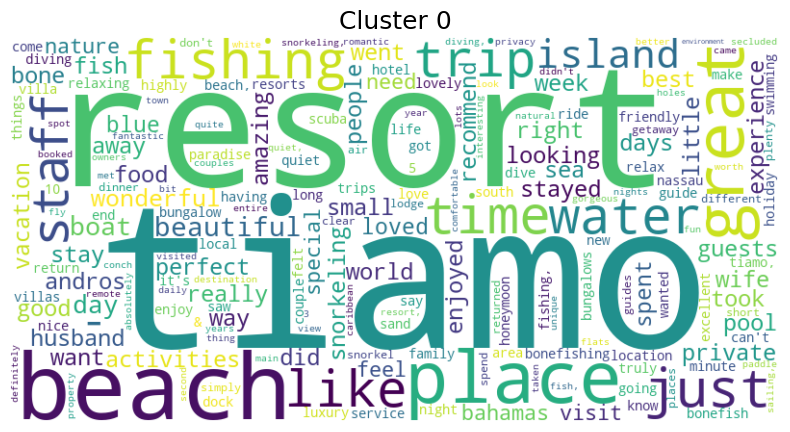

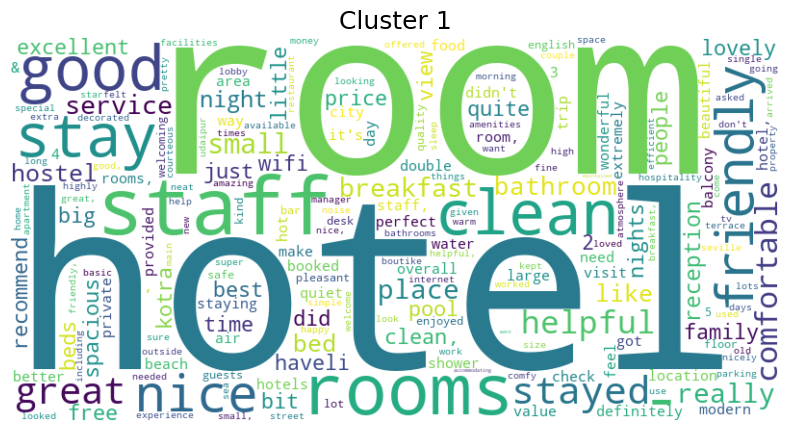

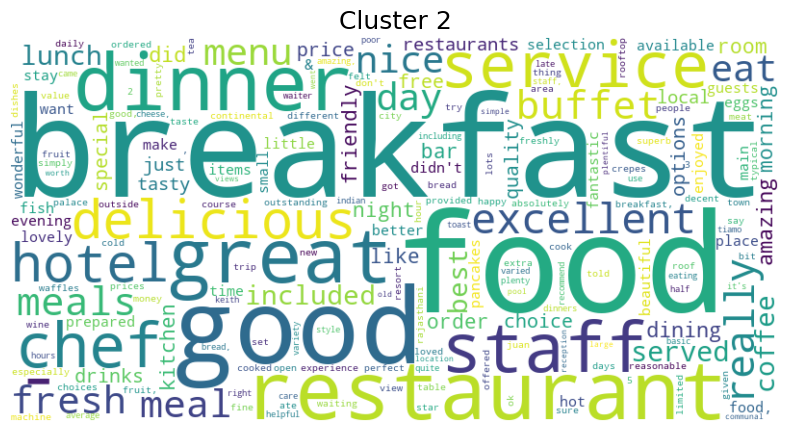

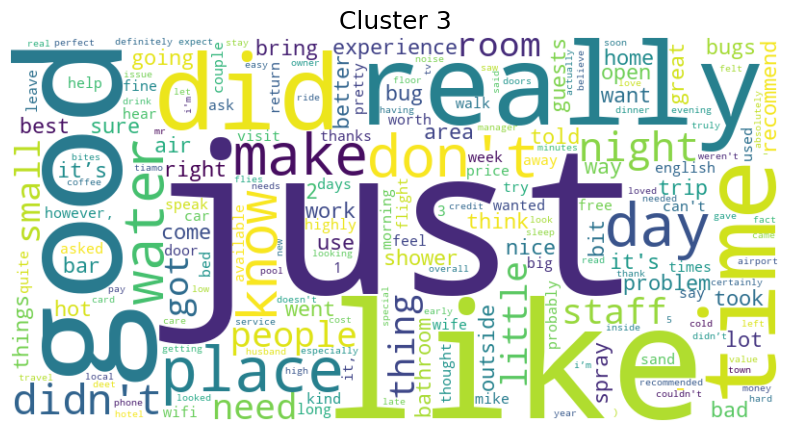

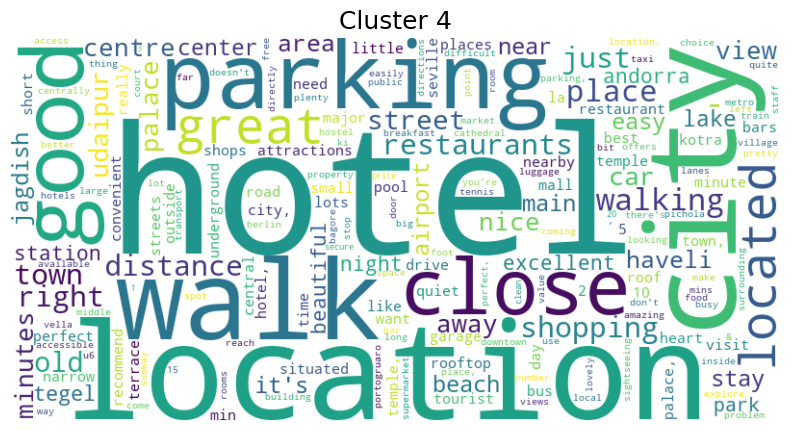

In [336]:
for cluster in range(5):
    
    cluster_word_counts = {k[1]: v for k, v in word_count.items() if k[0] == cluster}
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(cluster_word_counts)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}", fontsize=18)
    plt.show()

* Cluster 1 seems to focus on experiences and the facilities
* Cluster 2 On the rooms
* Cluster 3 On breakfast and the food
* Cluster 4 Seams to speak about the staff, but it isn't that clear
* Cluster 5 on location and parking

Let's see if we get more interesting topics when using HDBSCAN

In [42]:
hdbscan_clus = HDBSCAN(min_cluster_size=50,metric='cosine').fit(embeddings)

In [46]:
clusters = hdbscan_clus.labels_

In [47]:
set(clusters)

{-1, 0, 1}

In [48]:
pd.Series(clusters).value_counts()

-1    8853
 0     331
 1      91
Name: count, dtype: int64

This doesn't look promising. Most of the embedding fall in a cluster containing so-called noisy samples.

In [49]:
word_count = {}

for cluster, sentence in zip(labels,sentences):

    for word in sentence.split():
        if word.lower() not in ENGLISH_STOP_WORDS:
            word_count[(cluster,word.lower())] = word_count.get((cluster,word.lower()),0) + 1
    

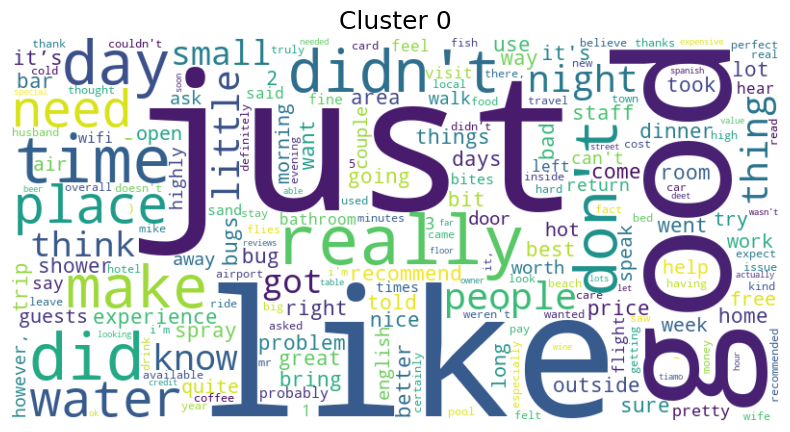

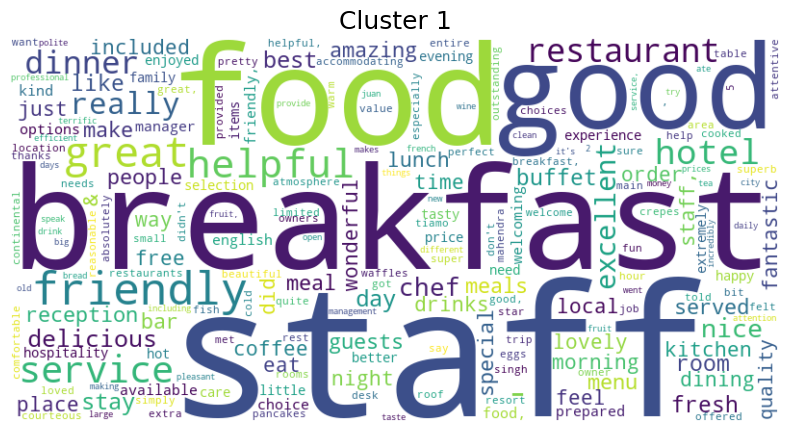

In [50]:
for cluster in range(2):
    
    cluster_word_counts = {k[1]: v for k, v in word_count.items() if k[0] == cluster}
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(cluster_word_counts)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}", fontsize=18)
    plt.show()

These two clusters are less intuitive and all the topics are assigned to the 2nd cluster